Did not converge within the given time frame


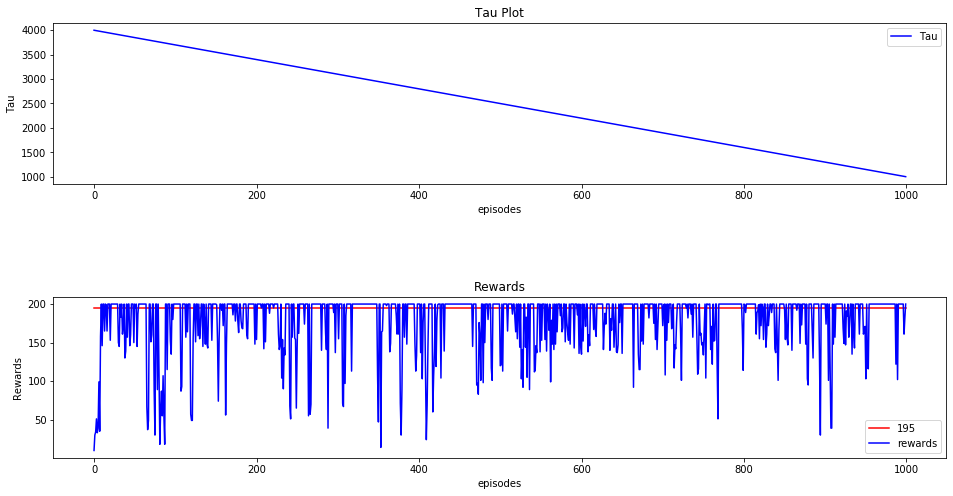

In [4]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
import random

env = gym.make('CartPole-v0')
class Qlearning():
    def __init__(self,bins=(1, 1, 6, 12), max_episodes = 2000, max_steps = 200,min_alpha=0.1, min_epsilon=0.1, epsilon = 1.0, gamma = 1.0, decay = 25, solved=False, action_space = env.action_space.n):   #max_env_steps=None
        self.bins = bins #(1, 1, 6, 12)--> number of buckets for each action space
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 0.97 # learning rate hyperparameter
        self.beta = 0.5# learning rate hyperparameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.action_space = action_space
        self.env = gym.make('CartPole-v0')
        self.QTable = np.zeros((self.bins + (self.action_space,))) #The Q-matrix has now a dimension of (1 x 1 x 6 x 12 x 2).
        self.actions = None
        self.tau = 4000    # tau --> 0 pure exploitation tau --> infinity pure exploration
        self.tau_decay = True
        self.decay_factor_tau = 1.50
        
    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]  #UNDERSTAND HOW THIS WORKS
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(upper_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) #multiply the bucket size by the bucket # scaling the buckets so that the state is reduced#  - 1makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) 
            descretizedList.append(new_obs)
        return tuple(descretizedList)
    
    def Boltzmann(self, state, tau):
        qList = self.QTable[state] 
        self.actions = [i for i in range(0, env.action_space.n)]
        if self.tau > 0.0:
            action_probs_numes = []
            denom = 0
            for q in qList:
                if self.tau == 2.5:
                    print((q / self.tau))
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val  # summation of the values
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
        else:
            action = np.argmax(self.QTable[state])
        return action
    
    def action_policy(self, state, policy):
        return policy[state]

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            new_tau = self.tau - self.decay_factor_tau
        if new_tau <= 0.0:
            self.tau = 0.00
        else:
            self.tau = new_tau
        return new_tau
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem  
        return step_size
    
    
#1-ln(time unit/decay)
    def learning(self):
        listof100 = deque(maxlen=100) #https://stackoverflow.com/questions/5944708/python-forcing-a-list-to-a-fixed-size
        rewards = []
        alphaList = []
        taus = []
        for e in range(self.max_episodes):  
            state = self.discretize(self.env.reset())
            step_size = 0.01
            tau = self.decay_tau(e)
            i = 0
            for t in range(self.max_steps):
                step_size = self.decay_step_size(t)
                if e%2==0:
                    #print(tau)
                    action = self.Boltzmann(state, tau) #, epsilon)
                if e%2==1:
                    action = self.action_policy(state, policy)
                new_state, reward, done, info = self.env.step(action)
                new_state = self.discretize(new_state)
                self.Q_Update(state, action, reward, new_state, step_size)
                state = new_state
                i += 1
                if done:
                    break
            stateTuple = list()
            stateList = []
            actionsList = []
            states = []
            #print(self.QTable)
            for list1 in self.QTable:
                for nextList in list1:
                    for nextList1 in nextList:
                        for nextList2 in nextList1:
                            actions = np.argmax(nextList2)
                            actionsList.append(actions)
            observations = np.argwhere(self.QTable>=0)
            j = 0
            for obsList in observations:
                stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3])
                stateList.append(stateTuple)
            del stateList[1::2]
            policy = dict(zip(stateList, actionsList))
            if e%2==1:
                listof100.append(i)
                mean_listof100 = np.mean(listof100)
                rewards.append(i)
                alphaList.append(step_size)
                mean_rewards =  np.mean(rewards)
                taus.append(self.tau)
                if mean_listof100 >= self.max_steps and e >= 100:
                    print("Solved after " + str(e) + " episodes.")
                    return rewards, alphaList, taus
        print("Did not converge within the given time frame")
        return rewards, alphaList, taus


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    rewards, alpha, tau = solve.learning()
    #print(tau)
    listof_195 = []
    for episode in range(len(rewards)):
        listof_195.append(195)
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(211)#311)
    ax1.plot(tau,  # epsilon_hist,
             color='b',
             label='Tau')
    ax1.set(title='Tau Plot',
            ylabel='Tau',
            xlabel='episodes')
    """ax2 = fig.add_subplot(312)
    ax2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    ax3 = fig.add_subplot(212)#313)
    ax3.plot(listof_195,  # epsilon_hist,
             color='r',
             label='195')
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')
    fig.subplots_adjust(hspace=0.7)
    ax1.legend(loc='best')
    #ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()


I decreased Tau linearly with the minumum Tau being 0.01 so that there would be some level of exploration even when tau wasn't decaying. also tried constant decay, and the system does not come close to convergeing. The step size decay I used here was the step size decay you gave me. And after settling on a value for tau I again ran this code for the many step sizes, and again 1.0 alpha, and 0.5 beta seems to work the best. I however still have room to improve and fine tune the numbers so that the system doesn't just hover around the right number but also consistantly scores above 195 for the 100 consecutive episode.